# Imports

In [1]:
import math,random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from nilearn.masking import apply_mask,intersect_masks
from nilearn.plotting import plot_glass_brain
from nilearn.image import load_img,index_img

C:\Users\nicol\miniconda3\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Loading data

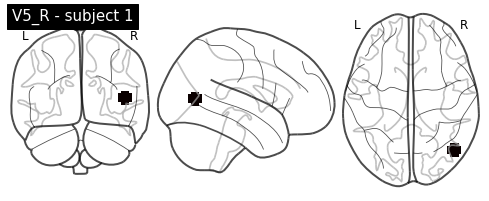

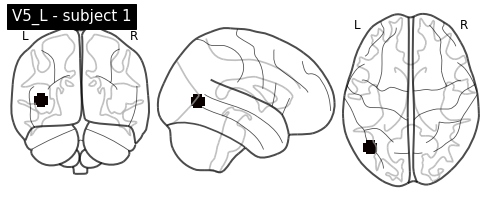

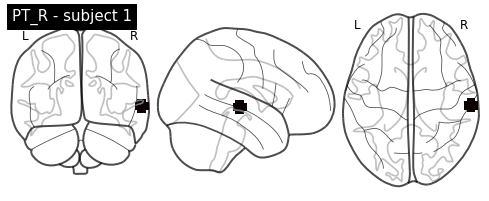

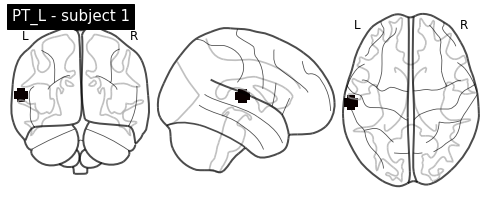

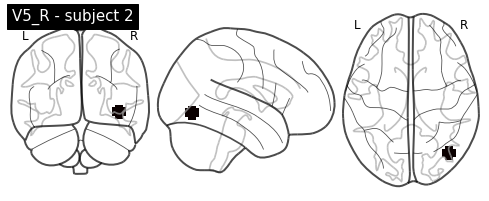

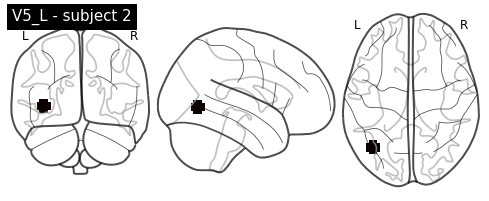

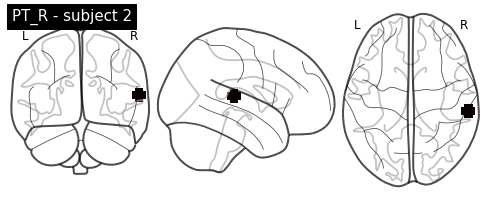

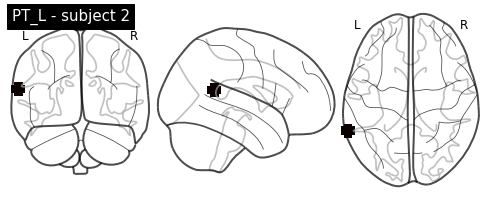

In [2]:
nb_subjects = 2
classes = ['vis_U','vis_D','vis_R','vis_L','aud_U','aud_D','aud_R','aud_L']
masks_names = ['V5_R','V5_L','PT_R','PT_L']

t_maps = [None]*nb_subjects
beta_maps = [None]*nb_subjects
masks = [None]*nb_subjects
masks_full = [None]*nb_subjects

for i in range(nb_subjects): 
    t_maps[i] = load_img("brain_maps/sub"+str(i+1)+"_4D_t_maps_0.nii")
    beta_maps[i] = load_img("brain_maps/sub"+str(i+1)+"_4D_beta_0.nii")
    masks_full[i] = load_img("masks/WHOLE_sub"+str(i+1)+".nii")
    masks[i] = dict()
    for name in masks_names:
        masks[i][name] = load_img("masks/ROI_sub"+str(i+1)+"_"+name+".nii")
        plot_glass_brain(masks[i][name], title = name+" - subject "+str(i+1))


# Motion decoding

In [7]:
# 1. create and apply apply masks 
masks_vis = [None]*nb_subjects
masks_aud = [None]*nb_subjects
length = int(t_maps[0].shape[3]/2)
t_maps_masked_V5_R = [None]*nb_subjects
t_maps_masked_V5_L = [None]*nb_subjects
t_maps_masked_V5_R_aud = [None]*nb_subjects
t_maps_masked_V5_L_aud = [None]*nb_subjects
t_maps_masked_PT_R = [None]*nb_subjects
t_maps_masked_PT_L = [None]*nb_subjects
t_maps_full_vis = [None]*nb_subjects
t_maps_full_aud = [None]*nb_subjects

for i in range(nb_subjects):
    # for the vision experiment
    t_maps_masked_V5_R[i] = apply_mask(index_img(t_maps[i],range(length)),masks[i]['V5_R'])
    t_maps_masked_V5_L[i] = apply_mask(index_img(t_maps[i],range(length)),masks[i]['V5_L'])
    t_maps_full_vis[i] = apply_mask(index_img(t_maps[i],range(length)),masks_full[i])
    
    # for the audition experiment
    t_maps_masked_PT_R[i] = apply_mask(index_img(t_maps[i],range(length,2*length)),masks[i]['PT_R'])
    t_maps_masked_PT_L[i] = apply_mask(index_img(t_maps[i],range(length,2*length)),masks[i]['PT_L'])
    t_maps_full_aud[i] = apply_mask(index_img(t_maps[i],range(length,2*length)),masks_full[i])

    # for decode audition using V5
    t_maps_masked_V5_R_aud[i] = apply_mask(index_img(t_maps[i],range(length,2*length)),masks[i]['V5_R'])
    t_maps_masked_V5_L_aud[i] = apply_mask(index_img(t_maps[i],range(length,2*length)),masks[i]['V5_L'])

In [20]:
# 2. create labels
class_labels = [None]*(length*2)
nb_runs = 12

for i in range(length*2) : 
    class_labels[i]=classes[i // nb_runs]
    
labels_vis = np.array(class_labels[:length])
labels_aud = np.array(class_labels[length:])
labels_vis_short = np.array([label[4] for label in labels_vis])
labels_aud_short = np.array([label[4] for label in labels_aud])

In [13]:
# 3. decode
def cross_validate(model,brain_map,labels,n_splits,return_model=False):
    acc=0
    for ind in range(n_splits) :
        test_index = range(ind,len(brain_map),n_splits)
        train_index = range(0,len(brain_map))
        train_index = [ind for ind in train_index if ind not in test_index]

        X_train,X_test = brain_map[train_index],brain_map[test_index]
        y_train,y_test = labels[train_index],labels[test_index]

        model.fit(X_train,y_train)
        score = model.score(X_test,y_test)
        acc += score

    final_score = acc/n_splits
        
    if return_model :
        model.fit(brain_map,labels) # re-fitting the model on all data
        return final_score,model
    else :
        return final_score

In [32]:
def p_value_random_permutations(n_perm,model,brain_map,labels,n_splits,base_score):
    count = 0
    for iter in range(n_perm) :
        labels_copy = labels.copy()
        random.shuffle(labels_copy)
        score_perm = cross_validate(model,brain_map,labels_copy,n_splits)
        if score_perm > base_score :
            count += 1
    
    return count/n_perm    

#### Visual motion 

In [33]:
classifier_vis = sklearn.svm.SVC(C=1) #default parameters, there is clearly improvements to be made here

for i in range(nb_subjects) :
    score_vis_masked_V5_R = cross_validate(classifier_vis,t_maps_masked_V5_R[i],labels_vis,12)
    print("cv score for V5 R sub"+str(i+1)+" is "+str(score_vis_masked_V5_R))
    p_value = p_value_random_permutations(1000,classifier_vis,t_maps_masked_V5_R[i],labels_vis,12,score_vis_masked_V5_R)
    print("estimated p-value for V5 R sub"+str(i+1)+" is "+str(p_value))

for i in range(nb_subjects) :
    score_vis_masked_V5_L = cross_validate(classifier_vis,t_maps_masked_V5_L[i],labels_vis,12)
    print("cv score for V5 L sub"+str(i+1)+" is "+str(score_vis_masked_V5_L))
    p_value = p_value_random_permutations(1000,classifier_vis,t_maps_masked_V5_L[i],labels_vis,12,score_vis_masked_V5_L)
    print("estimated p-value for V5 L sub"+str(i+1)+" is "+str(p_value))

cv score for V5 R sub1 is 0.3125
estimated p-value for V5 R sub1 is 0.002
cv score for V5 R sub2 is 0.4583333333333333
estimated p-value for V5 R sub2 is 0.0
cv score for V5 L sub1 is 0.3125
estimated p-value for V5 L sub1 is 0.006
cv score for V5 L sub2 is 0.1875
estimated p-value for V5 L sub2 is 0.022


#### Auditory motion 

In [85]:
classifier_aud = sklearn.svm.SVC(C=1) #default parameters, there is clearly improvements to be made here

for i in range(nb_subjects) :
    score_aud_masked_PT_R = cross_validate(classifier_aud,t_maps_masked_PT_R[i],labels_aud,12)
    print(" cv score for PT R sub"+str(i+1)+" is "+str(score_aud_masked_PT_R))
    p_value = p_value_random_permutations(1000,classifier_aud,t_maps_masked_PT_R[i],labels_aud,12,score_aud_masked_PT_R)
    print("estimated p-value for PT R sub"+str(i+1)+" is "+str(p_value))

for i in range(nb_subjects) :
    score_aud_masked_PT_L = cross_validate(classifier_aud,t_maps_masked_PT_L[i],labels_aud,12)
    print(" cv score for PT L sub"+str(i+1)+" is "+str(score_aud_masked_PT_L))
    p_value = p_value_random_permutations(1000,classifier_aud,t_maps_masked_PT_L[i],labels_aud,12,score_aud_masked_PT_L)
    print("estimated p-value for PT L sub"+str(i+1)+" is "+str(p_value))


 cv score for PT R sub1 is 0.25
estimated p-value for PT R sub1 is 0.025
 cv score for PT R sub2 is 0.2708333333333333
estimated p-value for PT R sub2 is 0.014
 cv score for PT L sub1 is 0.3541666666666667
estimated p-value for PT L sub1 is 0.002
 cv score for PT L sub2 is 0.22916666666666666
estimated p-value for PT L sub2 is 0.093


# Using V5 to predict auditory direction

In [31]:
classifier_aud_V5 = sklearn.svm.SVC(C=1) #default parameters, there is clearly improvements to be made here
for i in range(nb_subjects) :
    score_aud_masked_V5_R = cross_validate(classifier_aud_V5,t_maps_masked_V5_R_aud[i],labels_aud,12)
    print("cv score for V5 R sub"+str(i+1)+" audition is "+str(score_aud_masked_V5_R))
    p_value = p_value_random_permutations(1000,classifier_aud_V5,t_maps_masked_V5_R_aud[i],labels_aud,12,score_aud_masked_V5_R)
    print("estimated p-value for V5 R sub"+str(i+1)+" audition is "+str(p_value))

classifier_aud_V5_L = sklearn.svm.SVC(C=1) #default parameters, there is clearly improvements to be made here
for i in range(nb_subjects) :
    score_aud_masked_V5_L = cross_validate(classifier_aud_V5,t_maps_masked_V5_L_aud[i],labels_aud,12)
    print("cv score for V5 L sub"+str(i+1)+" audition is "+str(score_aud_masked_V5_L))
    p_value = p_value_random_permutations(1000,classifier_aud_V5,t_maps_masked_V5_L[i],labels_aud,12,score_aud_masked_V5_L)
    print("estimated p-value for V5 L sub"+str(i+1)+" audition is "+str(p_value))

cv score for V5 R sub1 audition is 0.2916666666666667
estimated p-value for V5 R sub1 audition is 0.012
cv score for V5 R sub2 audition is 0.2916666666666667
estimated p-value for V5 R sub2 audition is 0.007
cv score for V5 L sub1 audition is 0.25
estimated p-value for V5 L sub1 audition is 0.009
cv score for V5 L sub2 audition is 0.4375
estimated p-value for V5 L sub2 audition is 0.024


# Cross modal decoding using V5

In [21]:
# TRAINING ON VISION, TESTING ON AUDITION
classifier_cross_mod_V5 = sklearn.svm.SVC(C=1) #default parameters, there is clearly improvements to be made here

for i in range(nb_subjects) :
    score_vis,model = cross_validate(classifier_cross_mod_V5,t_maps_masked_V5_R[i],labels_vis_short,12,return_model=True)
    score_aud = model.score(t_maps_masked_V5_R_aud[i],labels_aud_short)
    print("cv score vis for sub"+str(i+1)+" R is "+str(score_vis)+" \n  aud score is "+str(score_aud))
    
for i in range(nb_subjects) :
    score_vis,model = cross_validate(classifier_cross_mod_V5,t_maps_masked_V5_R[i],labels_vis_short,12,return_model=True)
    score_aud = model.score(t_maps_masked_V5_R_aud[i],labels_aud_short)
    print("cv score vis for sub"+str(i+1)+" L is "+str(score_vis)+" \n  aud score is "+str(score_aud))

cv score vis for sub1 R is 0.3125 
 aud score is 0.3125
cv score vis for sub2 R is 0.4583333333333333 
 aud score is 0.25
cv score vis for sub1 L is 0.3125 
 aud score is 0.3125
cv score vis for sub2 L is 0.4583333333333333 
 aud score is 0.25


In [27]:
# TRAINING ON AUDITION, TESTING ON VISION
classifier_cross_mod_V5 = sklearn.svm.SVC(C=1) #default parameters, there is clearly improvements to be made here

for i in range(nb_subjects) :
    score_aud,model = cross_validate(classifier_cross_mod_V5,t_maps_masked_V5_R_aud[i],labels_aud_short,12,return_model=True)
    score_vis = model.score(t_maps_masked_V5_R[i],labels_vis_short)
    print("cv score aud for sub"+str(i+1)+" R is "+str(score_aud)+" \n  vis score is "+str(score_vis))
    
for i in range(nb_subjects) :
    score_aud,model = cross_validate(classifier_cross_mod_V5,t_maps_masked_V5_L_aud[i],labels_aud_short,12,return_model=True)
    score_vis = model.score(t_maps_masked_V5_L[i],labels_vis_short)
    print("cv score aud for sub"+str(i+1)+" L is "+str(score_aud)+" \n  vis score is "+str(score_vis))

cv score aud for sub1 R is 0.2916666666666667 
  vis score is 0.3541666666666667
cv score aud for sub2 R is 0.2916666666666667 
  vis score is 0.25
cv score aud for sub1 L is 0.25 
  vis score is 0.2916666666666667
cv score aud for sub2 L is 0.4375 
  vis score is 0.22916666666666666
